In [1]:
# !pip uninstall fsspec -y
# !pip install --upgrade fsspec
# !pip install transformers accelerate datasets

# Define

In [2]:
import os
import math
import random
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup

from sklearn.model_selection import KFold

import gc
gc.enable()

In [3]:
test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
submission_df = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")

In [4]:
data = pd.read_csv("../input/commonlitreadabilityprize/train.csv")

data.drop(data[(data.target == 0) & (data.standard_error == 0)].index,
              inplace=True)
data.reset_index(drop=True, inplace=True)

NUM_FOLDS = 5
NUM_EPOCHS = 3
BATCH_SIZE = 16
MAX_LEN = 248
SEED = 1000


kfold = KFold(n_splits=NUM_FOLDS, random_state=SEED, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(data)): 
    
    print("********",fold,"********")
    data.loc[val_indices, 'fold'] = fold
    # traindf1,val_df1 = train_df.iloc[train_indices],train_df.iloc[val_indices]

data

******** 0 ********
******** 1 ********
******** 2 ********
******** 3 ********
******** 4 ********


,id,url_legal,license,excerpt,target,standard_error,fold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,3.0
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,1.0
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,4.0
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,0.0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,0.0
...,...,...,...,...,...,...,...
2828,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,2.0
2829,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,4.0
2830,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,3.0
2831,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,1.0


In [5]:
# data.head(20)

In [6]:
NUM_FOLDS = 5
NUM_EPOCHS = 3
BATCH_SIZE = 8
MAX_LEN = 248
EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
ROBERTA_PATH = "../input/roberta-large-20210712191259-mlm/clrp_roberta_large"
TOKENIZER_PATH = "../input/roberta-large-20210712191259-mlm/clrp_roberta_large"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

In [8]:
class LitDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only
        self.text = df.excerpt.tolist()
        #self.text = [text.replace("\n", " ") for text in self.text]
        
        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32)        
    
        self.encoded = tokenizer.batch_encode_plus(
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True,
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index):        
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        
        if self.inference_only:
            return (input_ids, attention_mask)            
        else:
            target = self.target[index]
            return (input_ids, attention_mask, target)

In [9]:
class LitModel(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(ROBERTA_PATH)
        config.update({"output_hidden_states":True, 
                       "hidden_dropout_prob": 0.0,
                       "layer_norm_eps": 1e-7})                       
        
        self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config)  
        #https://towardsdatascience.com/attention-based-deep-multiple-instance-learning-1bb3df857e24
        # 768: node fully connected layer
        # 512: node attention layer
        # self.attention = nn.Sequential(            
        #     nn.Linear(768, 512),            
        #     nn.Tanh(),                       
        #     nn.Linear(512, 1),
        #     nn.Softmax(dim=1)
        # )        

        # self.regressor = nn.Sequential(                        
        #     nn.Linear(768, 1)                        
        # )

        #768 -> 1024
        #512 -> 768
        self.attention = nn.Sequential(            
            nn.Linear(1024, 768),            
            nn.Tanh(),                       
            nn.Linear(768, 1),
            nn.Softmax(dim=1)
        )        

        self.regressor = nn.Sequential(                        
            nn.Linear(1024, 1)                        
        )
        

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(input_ids=input_ids,
                                      attention_mask=attention_mask)        

        # There are a total of 13 layers of hidden states.
        # 1 for the embedding layer, and 12 for the 12 Roberta layers.
        # We take the hidden states from the last Roberta layer.
        last_layer_hidden_states = roberta_output.hidden_states[-1]

        # The number of cells is MAX_LEN.
        # The size of the hidden state of each cell is 768 (for roberta-base).
        # In order to condense hidden states of all cells to a context vector,
        # we compute a weighted average of the hidden states of all cells.
        # We compute the weight of each cell, using the attention neural network.
        weights = self.attention(last_layer_hidden_states)
                
        # weights.shape is BATCH_SIZE x MAX_LEN x 1
        # last_layer_hidden_states.shape is BATCH_SIZE x MAX_LEN x 768        
        # Now we compute context_vector as the weighted average.
        # context_vector.shape is BATCH_SIZE x 768
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)        
        
        # Now we reduce the context vector to the prediction score.
        return self.regressor(context_vector)

In [10]:
def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval()

    result = np.zeros(len(data_loader.dataset))    
    index = 0
    
    with torch.no_grad():
        for batch_num, (input_ids, attention_mask) in enumerate(data_loader):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
                        
            pred = model(input_ids, attention_mask)                        

            result[index : index + pred.shape[0]] = pred.flatten().to("cpu")
            index += pred.shape[0]

    return result

# stacking

In [11]:

pred = []
pred0 = []
pred1 = []
pred2 = []
pred3 = []
pred4 = []

FOLDS = 5
EPOCHS = 3
BATCH = 8
MAX_LEN = 248
TOKENIZER_PATH = "../input/roberta-large-20210712191259-mlm/clrp_roberta_large"

# all_predictions = np.zeros((5, len(x_val)))

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

for fold in range(FOLDS):

    x_train = data.loc[data.fold != fold, 'excerpt'].tolist()
    y_train = data.loc[data.fold != fold, 'target'].values
    # x_val = data.loc[data.fold == fold, 'excerpt'].tolist()
    # x_val = data.loc[data.fold == fold, 'excerpt']
    x_val = data[['id','excerpt']].loc[data.fold == fold]
    y_val = data.loc[data.fold == fold, 'target'].values

    

    test_dataset = LitDataset(x_val, inference_only=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH,
                         drop_last=False, shuffle=False, num_workers=2)

    print(f'*** fold = {fold} ***')

    #CHANGEME
    model_path = f"../input/roberta-large-20210720020531-sch/model_{fold + 1}.pth"
    print(f"\nUsing {model_path}")
    
    model = LitModel()
#     model = MeanPoolingModel(MODEL_NAME)
    model.load_state_dict(torch.load(model_path))  
    model.to(DEVICE)
    
    if fold == 0:
        pred0 = predict(model, test_loader)
        x_fold0 = x_val.copy()
        x_fold0['meanpooling pred'] = pred0
        print(f"pred{fold} len : ",len(pred0))

    elif fold == 1:
        
        pred1 = predict(model, test_loader)
        x_fold1 = x_val.copy()
        x_fold1['meanpooling pred'] = pred1
        print(f"pred{fold} len : ",len(pred1))

    elif fold == 2:
        
        pred2 = predict(model, test_loader)
        x_fold2 = x_val.copy()
        x_fold2['meanpooling pred'] = pred2
        print(f"pred{fold} len : ",len(pred2))

    elif fold == 3:
        
        pred3 = predict(model, test_loader)
        x_fold3 = x_val.copy()
        x_fold3['meanpooling pred'] = pred3
        print(f"pred{fold} len : ",len(pred3))

    elif fold == 4:
        
        pred4 = predict(model, test_loader)
        x_fold4 = x_val.copy()
        x_fold4['meanpooling pred'] = pred4
        print(f"pred{fold} len : ",len(pred4))

    # pred = predict(model, test_loader)
    # x_val['pred'] = pred
    
    del model
    gc.collect()

*** fold = 0 ***

Using ../input/roberta-large-20210720020531-sch/model_1.pth


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/roberta-large-20210712191259-mlm/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pred0 len :  567
*** fold = 1 ***

Using ../input/roberta-large-20210720020531-sch/model_2.pth


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/roberta-large-20210712191259-mlm/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pred1 len :  567
*** fold = 2 ***

Using ../input/roberta-large-20210720020531-sch/model_3.pth


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/roberta-large-20210712191259-mlm/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pred2 len :  567
*** fold = 3 ***

Using ../input/roberta-large-20210720020531-sch/model_4.pth


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/roberta-large-20210712191259-mlm/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pred3 len :  566
*** fold = 4 ***

Using ../input/roberta-large-20210720020531-sch/model_5.pth


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/roberta-large-20210712191259-mlm/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pred4 len :  566


# 元データにマージ

In [12]:
df_concat = pd.concat([x_fold0, x_fold1, x_fold2, x_fold3, x_fold4])
df_meanpooling = pd.merge(data, df_concat, on='id')

df_meanpooling = df_meanpooling.drop(['url_legal','license','standard_error','fold','excerpt_y'],axis = 1).rename({'excerpt_x':'excerpt'},axis=1)
df_meanpooling

,id,excerpt,target,meanpooling pred
0,c12129c31,When the young people returned to the ballroom...,-0.340259,-0.360790
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,-0.222800
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,-0.551704
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,-1.231399
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.139402
...,...,...,...,...
2828,25ca8f498,When you think of dinosaurs and where they liv...,1.711390,0.570218
2829,2c26db523,So what is a solid? Solids are usually hard be...,0.189476,0.078175
2830,cd19e2350,The second state of matter we will discuss is ...,0.255209,-0.327771
2831,15e2e9e7a,Solids are shapes that you can actually touch....,-0.215279,-1.367640


# plot

<AxesSubplot:xlabel='meanpooling pred', ylabel='target'>

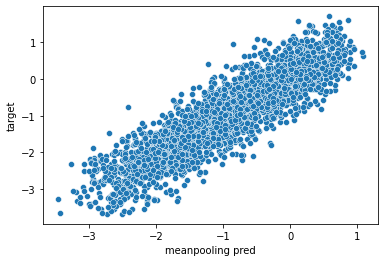

In [13]:
import seaborn as sns

sns.scatterplot(data=df_meanpooling, x='meanpooling pred', y='target')

In [14]:
df_meanpooling.to_csv('nishipy_robertalarge_stacking.csv',index=False)

# Predict and submit

In [15]:
# all_predictions = np.zeros((5, len(test_df)))

# test_dataset = LitDataset(test_df, inference_only=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
#                          drop_last=False, shuffle=False, num_workers=2)

# for index in range(5):
#     #CHANGEME
#     model_path = f"../input/roberta-large-20210720020531-sch/model_{index + 1}.pth"
#     print(f"\nUsing {model_path}")
                        
#     model = LitModel()
#     model.load_state_dict(torch.load(model_path))    
#     model.to(DEVICE)
    
#     all_predictions[index] = predict(model, test_loader)
    
#     del model
#     gc.collect()

In [16]:
# predictions = all_predictions.mean(axis=0)
# submission_df.target = predictions
# print(submission_df)
# submission_df.to_csv("submission.csv", index=False)